In [2]:
from tensorflow import keras
import tensorflow as tf
from keras.models import Input, Model
from keras.layers import Dense
from pycalphad import Database, calculate, variables as v
import numpy as np

In [3]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'VA']

In [4]:
res = calculate(dbf, comps, 'LIQUID', T=1000, P=1e5, N=1, pdens=500)

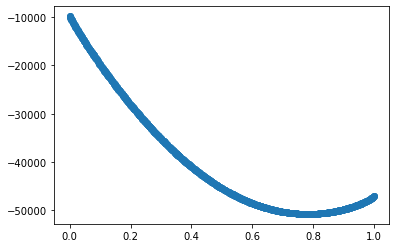

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(res.Y[..., 0], res.GM)

In [41]:
site_fractions = res.Y.values
print(site_fractions.shape)

(1, 1, 1, 1002, 2)


In [197]:
filtered = res.drop_vars('component').to_dataframe()[['Y', 'GM']] \
                .unstack('internal_dof')\
                .droplevel(level='component')\
                .drop_duplicates()\
                .reset_index()\
                .drop(columns=['N', 'P', 'points'])
# Not sure how to fix the duplicate energy column yet
filtered = filtered.values[:, :1+site_fractions.shape[-1]+1]
x_orig = filtered[:, :-1]
y_orig = filtered[:, -1]

In [256]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from numpy.polynomial.legendre import legvander2d
from keras.layers import Dropout

print('Number of training points: ', x.shape[0])

x = x_orig[:, 1:]
y_unscaled = y_orig #- 8.3145 * 1000 * (x[:, 0] * np.log(x[:, 0]) + x[:, 1] * np.log(x[:, 1]))
y = (y_unscaled - y_unscaled.mean())/y_unscaled.std()
print('Number of features: ', x.shape[1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1769)
inputs = Input(shape=(x.shape[1],))
output = Dense(20, activation='relu', use_bias=True)(inputs)
output = Dense(1, activation='linear', use_bias=True)(output)
linear_model = Model(inputs, output)
linear_model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), loss='mse')

Number of training points:  1000
Number of features:  2


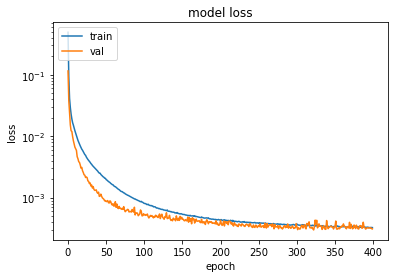

In [257]:
# Fit on training data
history = linear_model.fit(x=x_train, y=y_train, epochs=400, validation_data=(x_test, y_test), verbose=0,
                           callbacks=keras.callbacks.TerminateOnNaN())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

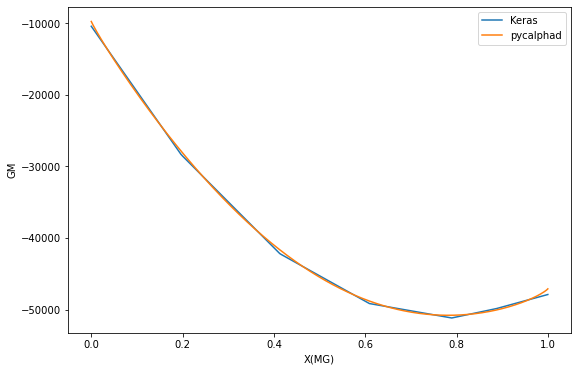

In [258]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
model_y = linear_model.predict(x, batch_size=1)
px_idx = np.argsort(x[:, 0])
px = x[px_idx, 0]
py = (y[px_idx] * y_unscaled.std()) + y_unscaled.mean()
model_py = (model_y[px_idx] * y_unscaled.std()) + y_unscaled.mean()
ax.plot(px, model_py, label='Keras')
ax.plot(px, py, label='pycalphad')
ax.set_xlabel('X(MG)')
ax.set_ylabel('GM')
ax.legend()

In [260]:
linear_model.get_weights()

[array([[-0.04879113,  0.37199906,  0.10334485, -0.25364935, -0.16552006,
         -0.44377407, -0.24428943,  0.22472237, -0.08308657,  0.33575332,
         -0.9470334 , -0.64596653, -0.7537729 , -0.21249443,  0.14942324,
          0.32625547, -0.7965825 , -0.10106641, -0.10123798,  0.39382306],
        [ 0.3727679 ,  0.29754862,  0.34443226, -0.3361237 ,  0.6056534 ,
         -0.21614072, -0.5024386 , -0.4570667 ,  0.01998393,  0.06803689,
          0.7911289 ,  1.0348861 ,  0.9653412 , -0.08570847,  0.57024693,
          0.07500172,  1.0404396 , -0.18792075, -0.33081383, -0.10710867]],
       dtype=float32),
 array([ 0.14652225,  0.00053861,  0.00594265,  0.        ,  0.2826043 ,
         0.        ,  0.        , -0.1468193 , -0.32211024, -0.01926522,
        -0.44837323,  0.2921347 ,  0.08210158,  0.        ,  0.30254006,
         0.50086504, -0.28125173,  0.        ,  0.        ,  0.32460597],
       dtype=float32),
 array([[-0.44152096],
        [-0.08544476],
        [-0.16647844